In [1]:
%load_ext autoreload
%autoreload 2
from utils.utils import *
from utils.utils_train import *

In [2]:
# Load SBERT Embeddings
queries, query_embeddings, product_embeddings = load_raw_queries()

# load ids_toys from disk
with open('output/ids_toys.pkl', 'rb') as file:
    ids_toys = pickle.load(file)
    print(len(ids_toys))
    ids_present = [_id for _id in ids_toys if _id in query_embeddings]

# Assemble qb & xb input embeddings
qb = torch.stack([torch.tensor(query_embeddings[_id]) for _id in ids_present])
xb = torch.tensor(np.array([product_embeddings[_id] for _id in ids_present]))

# Split Dataset into Train and Test
(qb_train, qb_test), (xb_train, xb_test), (idx_train, idx_test) = shuffle_and_split(qb, xb, seed=12)
print('qb_train.shape:', qb_train.shape)
print('qb_test.shape:', qb_test.shape)


loaded (queries, query_embeddings, product_embeddings) from  output/raw_queries.pkl
84373
qb_train.shape: torch.Size([20560, 768])
qb_test.shape: torch.Size([5140, 768])


In [3]:
# Two-Tower Pytorch Model
d = hidden_dim = qb.shape[-1]
learning_rate = 0.0001

# Initialize the network
model = TwoTowerNetwork(d, hidden_dim, learning_rate=learning_rate)

list_recall3 = []
list_test_epochs = []

recall@3  = 0.055                    
recall@3  = 0.133                    
recall@3  = 0.097                    
recall@3  = 0.033                    
recall@3  = 0.033                    
recall@3  = 0.052                    
recall@3  = 0.060                    
recall@3  = 0.072                    
recall@3  = 0.079                    
recall@3  = 0.089                    
recall@3  = 0.104                    
recall@3  = 0.109                    
recall@3  = 0.123                    
recall@3  = 0.132                    
recall@3  = 0.158                    
recall@3  = 0.177                    
recall@3  = 0.188                    
recall@3  = 0.217                    
recall@3  = 0.228                    
recall@3  = 0.241                    
recall@3  = 0.261                    
recall@3  = 0.275                    
recall@3  = 0.288                    
recall@3  = 0.308                    
recall@3  = 0.325                    


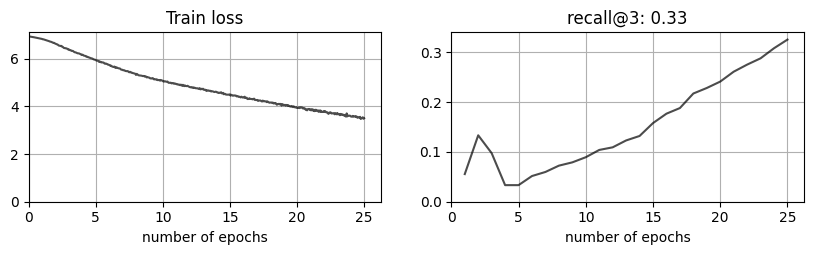

recall@3  = 0.329                    
recall@3  = 0.350                    
recall@3  = 0.359                    
recall@3  = 0.362                    
recall@3  = 0.387                    
recall@3  = 0.390                    
recall@3  = 0.398                    
recall@3  = 0.407                    
recall@3  = 0.413                    
recall@3  = 0.429                    
recall@3  = 0.437                    
recall@3  = 0.438                    
recall@3  = 0.461                    
recall@3  = 0.467                    
recall@3  = 0.477                    
recall@3  = 0.485                    
recall@3  = 0.498                    
recall@3  = 0.505                    
recall@3  = 0.513                    
recall@3  = 0.524                    
recall@3  = 0.541                    
recall@3  = 0.546                    
recall@3  = 0.545                    
recall@3  = 0.553                    
recall@3  = 0.560                    


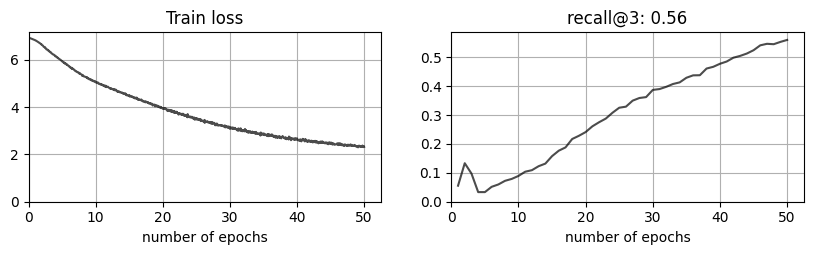

recall@3  = 0.568                    
recall@3  = 0.570                    
recall@3  = 0.584                    
recall@3  = 0.581                    
recall@3  = 0.591                    
recall@3  = 0.604                    
recall@3  = 0.601                    
recall@3  = 0.612                    
recall@3  = 0.612                    
recall@3  = 0.611                    
recall@3  = 0.626                    
recall@3  = 0.615                    
recall@3  = 0.620                    
recall@3  = 0.642                    
recall@3  = 0.642                    
recall@3  = 0.641                    
recall@3  = 0.652                    
recall@3  = 0.648                    
recall@3  = 0.659                    
recall@3  = 0.656                    
recall@3  = 0.662                    
recall@3  = 0.664                    
recall@3  = 0.678                    
recall@3  = 0.669                    
recall@3  = 0.674                    


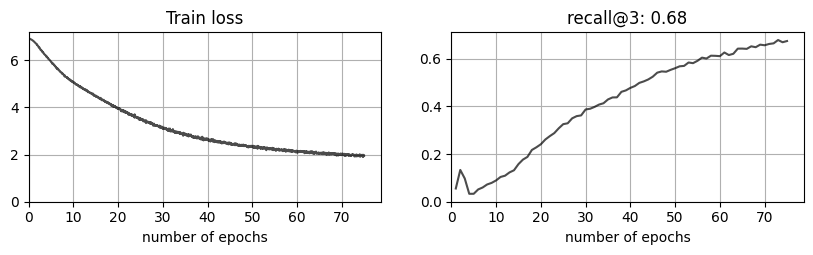

recall@3  = 0.673                    
recall@3  = 0.673                    
recall@3  = 0.688                    
recall@3  = 0.693                    
recall@3  = 0.693                    
recall@3  = 0.697                    
recall@3  = 0.694                    
recall@3  = 0.694                    
recall@3  = 0.690                    
recall@3  = 0.704                    
recall@3  = 0.699                    
recall@3  = 0.700                    
recall@3  = 0.706                    
recall@3  = 0.699                    
recall@3  = 0.703                    
recall@3  = 0.709                    
recall@3  = 0.703                    
recall@3  = 0.705                    
recall@3  = 0.709                    
recall@3  = 0.705                    
recall@3  = 0.704                    
recall@3  = 0.704                    
recall@3  = 0.710                    
recall@3  = 0.711                    
recall@3  = 0.714                    


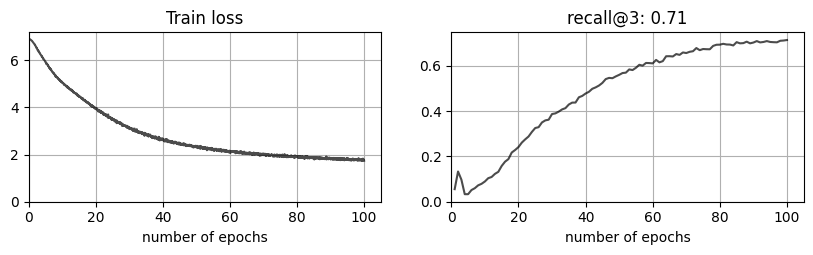

recall@3  = 0.711                    
recall@3  = 0.720                    
recall@3  = 0.717                    
recall@3  = 0.714                    
recall@3  = 0.713                    
recall@3  = 0.721                    
recall@3  = 0.710                    
recall@3  = 0.719                    
recall@3  = 0.711                    
recall@3  = 0.720                    
recall@3  = 0.712                    
recall@3  = 0.719                    
recall@3  = 0.714                    
recall@3  = 0.712                    
recall@3  = 0.715                    
recall@3  = 0.707                    
recall@3  = 0.723                    
recall@3  = 0.727                    
recall@3  = 0.724                    
recall@3  = 0.718                    
recall@3  = 0.717                    
recall@3  = 0.722                    
recall@3  = 0.717                    
recall@3  = 0.724                    
recall@3  = 0.723                    


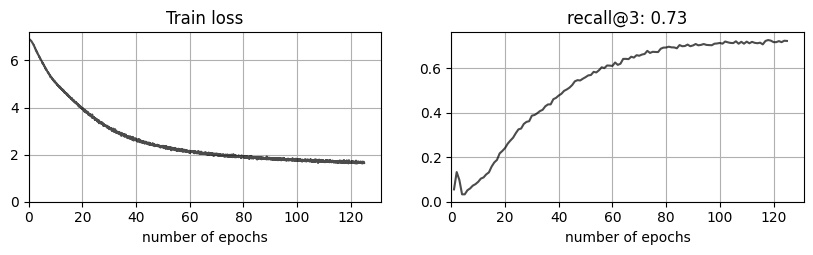

recall@3  = 0.728                    
recall@3  = 0.710                    
recall@3  = 0.729                    
recall@3  = 0.721                    
recall@3  = 0.721                    
recall@3  = 0.733                    
recall@3  = 0.715                    
recall@3  = 0.736                    
recall@3  = 0.726                    
recall@3  = 0.732                    
recall@3  = 0.723                    
recall@3  = 0.732                    
recall@3  = 0.716                    
recall@3  = 0.724                    
recall@3  = 0.726                    
recall@3  = 0.723                    
recall@3  = 0.732                    
recall@3  = 0.729                    
recall@3  = 0.729                    
recall@3  = 0.728                    
recall@3  = 0.727                    
recall@3  = 0.727                    
recall@3  = 0.737                    
recall@3  = 0.738                    
recall@3  = 0.724                    


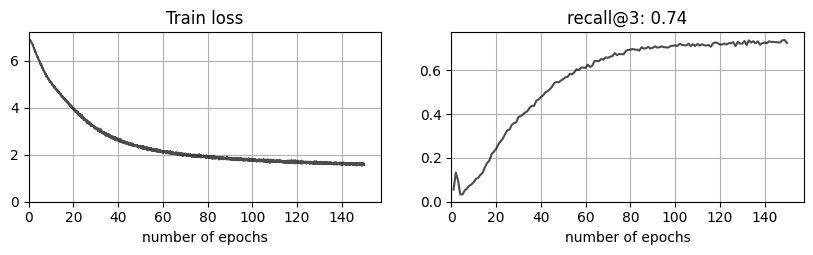

recall@3  = 0.738                    
recall@3  = 0.729                    
recall@3  = 0.737                    
recall@3  = 0.721                    
recall@3  = 0.720                    
recall@3  = 0.732                    
recall@3  = 0.731                    
recall@3  = 0.730                    
recall@3  = 0.733                    
recall@3  = 0.735                    
recall@3  = 0.721                    
recall@3  = 0.737                    
recall@3  = 0.729                    
recall@3  = 0.730                    
recall@3  = 0.738                    
recall@3  = 0.730                    
recall@3  = 0.730                    
recall@3  = 0.729                    
recall@3  = 0.718                    
recall@3  = 0.732                    
recall@3  = 0.725                    
recall@3  = 0.732                    
recall@3  = 0.733                    
recall@3  = 0.732                    
recall@3  = 0.727                    


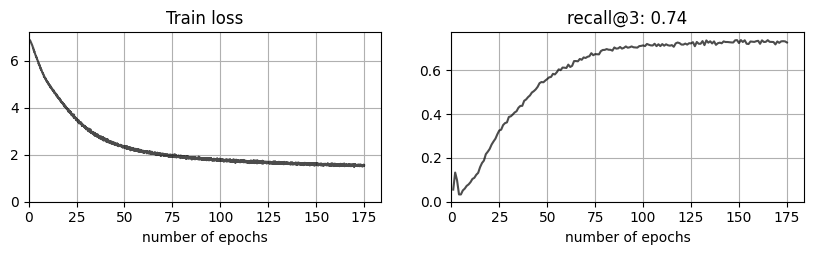

recall@3  = 0.730                    
recall@3  = 0.723                    
recall@3  = 0.735                    
recall@3  = 0.728                    
recall@3  = 0.735                    
recall@3  = 0.731                    
recall@3  = 0.734                    
recall@3  = 0.732                    
recall@3  = 0.733                    
recall@3  = 0.733                    
recall@3  = 0.738                    
recall@3  = 0.729                    
recall@3  = 0.722                    
recall@3  = 0.723                    
recall@3  = 0.723                    
recall@3  = 0.741                    
recall@3  = 0.724                    
recall@3  = 0.732                    
recall@3  = 0.731                    
recall@3  = 0.740                    
recall@3  = 0.735                    
recall@3  = 0.718                    
recall@3  = 0.724                    
recall@3  = 0.730                    
recall@3  = 0.718                    


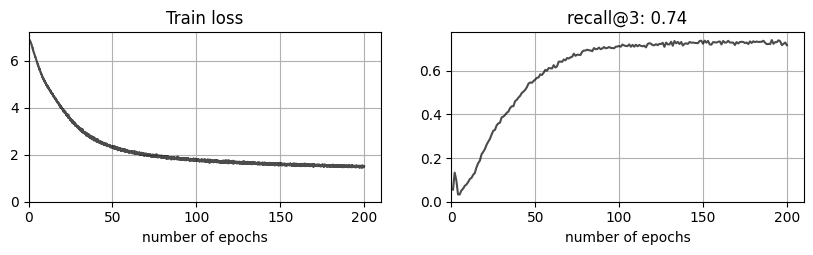

recall@3  = 0.722                    
recall@3  = 0.722                    
recall@3  = 0.740                    
recall@3  = 0.726                    
recall@3  = 0.732                    
recall@3  = 0.738                    
recall@3  = 0.715                    
recall@3  = 0.718                    
recall@3  = 0.725                    
recall@3  = 0.720                    
recall@3  = 0.714                    
recall@3  = 0.715                    
recall@3  = 0.712                    
recall@3  = 0.727                    
recall@3  = 0.717                    
recall@3  = 0.739                    
recall@3  = 0.722                    
recall@3  = 0.733                    
recall@3  = 0.722                    
recall@3  = 0.725                    
recall@3  = 0.745                    
recall@3  = 0.728                    
recall@3  = 0.710                    
recall@3  = 0.716                    
recall@3  = 0.717                    


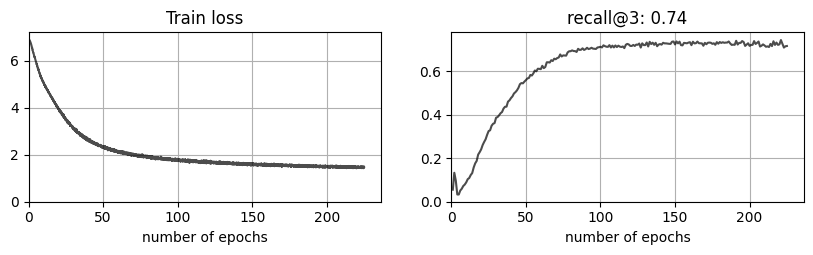

recall@3  = 0.726                    
recall@3  = 0.720                    
recall@3  = 0.731                    
recall@3  = 0.725                    
recall@3  = 0.732                    
recall@3  = 0.717                    
recall@3  = 0.718                    
recall@3  = 0.705                    
recall@3  = 0.717                    
recall@3  = 0.724                    
recall@3  = 0.733                    
recall@3  = 0.718                    
recall@3  = 0.717                    
recall@3  = 0.729                    
recall@3  = 0.721                    
recall@3  = 0.719                    
recall@3  = 0.711                    
recall@3  = 0.723                    
recall@3  = 0.706                    
recall@3  = 0.733                    
recall@3  = 0.714                    
recall@3  = 0.714                    
recall@3  = 0.714                    
recall@3  = 0.718                    
recall@3  = 0.714                    


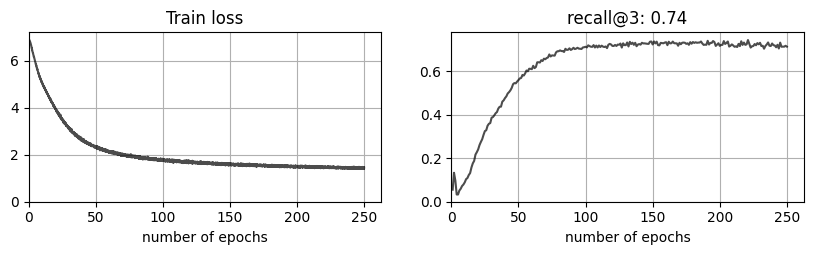

recall@3  = 0.725                    
recall@3  = 0.715                    
recall@3  = 0.723                    
recall@3  = 0.719                    
recall@3  = 0.715                    
recall@3  = 0.715                    
recall@3  = 0.724                    
recall@3  = 0.724                    
recall@3  = 0.709                    
recall@3  = 0.710                    
recall@3  = 0.739                    
recall@3  = 0.724                    
recall@3  = 0.712                    
recall@3  = 0.729                    
recall@3  = 0.721                    
recall@3  = 0.712                    
recall@3  = 0.714                    
recall@3  = 0.736                    
recall@3  = 0.721                    
recall@3  = 0.720                    
recall@3  = 0.720                    
recall@3  = 0.709                    
recall@3  = 0.715                    
recall@3  = 0.721                    
recall@3  = 0.706                    


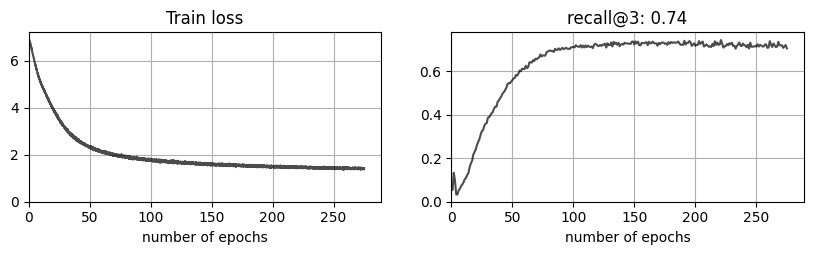

recall@3  = 0.716                    
recall@3  = 0.708                    
recall@3  = 0.710                    
recall@3  = 0.710                    
recall@3  = 0.705                    
recall@3  = 0.713                    
recall@3  = 0.706                    
recall@3  = 0.726                    
recall@3  = 0.720                    
recall@3  = 0.707                    
recall@3  = 0.706                    
recall@3  = 0.709                    
recall@3  = 0.715                    
recall@3  = 0.705                    
recall@3  = 0.710                    
recall@3  = 0.710                    
recall@3  = 0.706                    
recall@3  = 0.718                    
recall@3  = 0.710                    
recall@3  = 0.717                    
recall@3  = 0.714                    
recall@3  = 0.716                    
recall@3  = 0.716                    
recall@3  = 0.710                    
recall@3  = 0.715                    


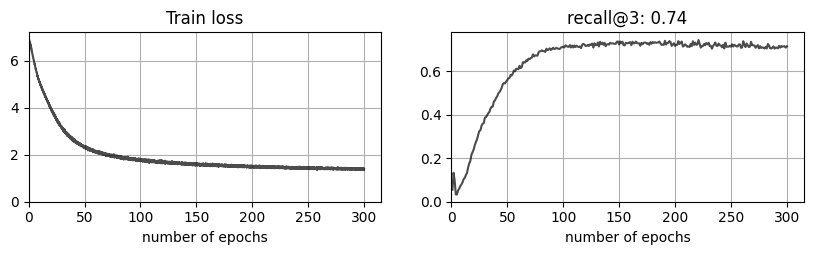

In [4]:
## TRAIN
# Hyperparameters
batch_size = 1024 
num_epochs = 1
label_smoothing = 0.1

for i in range(300):
    (qb_train, _), (xb_train, _), (_) = shuffle_and_split(qb_train, xb_train, split=1)
    
    model.train(qb_train, xb_train, num_epochs, batch_size, label_smoothing)
    write_output_embeddings(model, qb_test, xb_test) 
    os.system('cd utils && python3 utils_infer.py')
    with open('output/recall3.json', 'r') as file:
        out = json.load(file)
    recall3 = out['recall3']
    list_test_epochs.append(model.epochs[-1])
    list_recall3.append(recall3) 
    
    if (i+1) % 25 == 0:
        model.plot(qb_train, batch_size, list_test_epochs, list_recall3) 

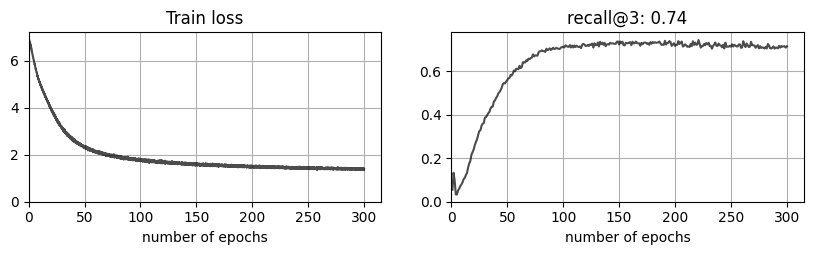

In [5]:
model.plot(qb_train, batch_size, list_test_epochs, list_recall3)


In [6]:
model

TwoTowerNetwork(
  (qb_tower): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): Dropout(p=0.1, inplace=False)
  )
  (xb_tower): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): Dropout(p=0.1, inplace=False)
  )
)

In [ ]:
# TODO:
# 1. figure out how to incorporate a learning_rate scheduler
# 2. print the top 3 results for hits. 

### The End

In [ ]:
# Load queries, ids_toys, ids_present
with open('output/raw_queries.pkl', 'rb') as file:
    queries, _, _ = pickle.load(file)

with open('output/ids_toys.pkl', 'rb') as file:
    ids_toys = pickle.load(file)
    ids_present = [_id for _id in ids_toys if _id in query_embeddings]


In [5]:
top_ids = [ids_present[idx_test[i]] for i in I[0]]
names = [info[_id]['name'] for _id in top_ids]
details = [info[_id]['details'] for _id in top_ids]
description = [info[_id]['description'] for _id in top_ids]
queries[ids_present[idx_test[0]]]

"I need to buy a Super-duper Tutu/Cape/Mask set in size 4-6 for my 4-6-year-old. It's a 3-piece set perfect for little Superheroines and Rock Stars!"